# Comidas Rápidas

Nuestro local de comida rápida, “Panis”, tiene mucho que aprender sobre teoría 
de colas. Insta a los clientes a que formen 3 colas en las que se distribuyen de 
forma aleatoria delante de los empleados durante el periodo de comidas diario. 
Además han instalado entre las tres colas barreras para que los clientes no se 
pasen a otras colas para prevenir que la gente se “cambie de cola”. Llegan los 
clientes según una distribución de Poisson con una media de 60 por hora y el 
tiempo en que un cliente es servido varía según una distribución exponencial de 
media 150 segundos. Asumiendo el estado permanente del sistema, ¿cuál es el 
tiempo medio de estancia del cliente hasta que ha sido atendido? El gerente de 
“Panis” ha creído ahora que es preferible una única cola para distribuir finalmente a 
los tres servidores y por tanto las barreras son eliminadas. ¿cuál es el tiempo de 
espera de este modo?

### Consideraciones iniciales

In [121]:
import simpy
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del sistema
LAMBDA = 60  # Tasa de llegadas (clientes/hora)
MU = 24      # Tasa de servicio por servidor (clientes/hora)
HORAS_SIMULACION = 1000  # Tiempo de simulación (suficiente para estado estable)

# Conversión a minutos para simulación
LAMBDA_MIN = LAMBDA / 60  # Clientes/minuto
MU_MIN = MU / 60          # Clientes/minuto

### Simulación para tres colas (cada cola funciona de forma independiente y de la misma manera)

In [122]:
def simulacion_tres_colas(env, lambd, mu, datos, clientes_en_cola_dict, clientes_en_sistema_dict):
    # Tres servidores independientes (cada uno es un recurso de simpy)
    servidores = [simpy.Resource(env, capacity=1) for _ in range(3)]

    clientes_en_cola = [0]
    clientes_en_sistema = [0]

    def cliente(env, servidor):
        nonlocal clientes_en_cola, clientes_en_sistema
        llegada = env.now
        clientes_en_cola[0] += 1
        clientes_en_cola_dict[llegada] = clientes_en_cola[0]
        clientes_en_sistema[0] += 1
        clientes_en_sistema_dict[llegada] = clientes_en_sistema[0]
        with servidor.request() as req:
            yield req
            inicio_servicio = env.now
            clientes_en_cola[0] -= 1
            clientes_en_cola_dict[inicio_servicio] = clientes_en_cola[0]
            tiempo_servicio = np.random.exponential(1/mu)
            yield env.timeout(tiempo_servicio)
            fin_servicio = env.now
            clientes_en_sistema[0] -= 1
            clientes_en_sistema_dict[fin_servicio] = clientes_en_sistema[0]
            datos.append({
                "llegada": llegada,
                "inicio_servicio": inicio_servicio,
                "fin_servicio": fin_servicio,
                "servidor": servidor
            })

    # Generación de clientes y asignación aleatoria a colas
    while True:
        yield env.timeout(np.random.exponential(1/lambd))
        servidor_idx = np.random.choice(3)
        env.process(cliente(env, servidores[servidor_idx]))

### Ejecución de la simulación para tres colas

In [ ]:
datos = []
clientes_en_cola_dict = {}
clientes_en_sistema_dict = {}

env = simpy.Environment()
env.process(simulacion_tres_colas(env, LAMBDA_MIN, MU_MIN, datos, clientes_en_cola_dict, clientes_en_sistema_dict))
env.run(until=HORAS_SIMULACION * 60)  # Convertir horas a minutos

# Cálculo de métricas (tiempos en minutos)
tiempos_cola = [d["inicio_servicio"] - d["llegada"] for d in datos]
tiempos_sistema = [d["fin_servicio"] - d["llegada"] for d in datos]
media_tres_colas = np.mean(tiempos_cola)
media_tres_colas_sistema = np.mean(tiempos_sistema)

### Simulación para una cola para tres servidores

In [124]:
def simulacion_una_cola(env, lambd, mu, num_servidores, datos, clientes_en_cola_dict, clientes_en_sistema_dict):
    servidor = simpy.Resource(env, capacity=num_servidores)
    
    clientes_en_cola = [0]
    clientes_en_sistema = [0]

    def cliente(env):
        nonlocal clientes_en_cola, clientes_en_sistema
        llegada = env.now
        clientes_en_cola[0] += 1
        clientes_en_cola_dict[llegada] = clientes_en_cola[0]
        clientes_en_sistema[0] += 1
        clientes_en_sistema_dict[llegada] = clientes_en_sistema[0]
        with servidor.request() as req:
            yield req
            inicio_servicio = env.now
            clientes_en_cola[0] -= 1
            clientes_en_cola_dict[inicio_servicio] = clientes_en_cola[0]
            tiempo_servicio = np.random.exponential(1/mu)
            yield env.timeout(tiempo_servicio)
            fin_servicio = env.now
            clientes_en_sistema[0] -= 1
            clientes_en_sistema_dict[fin_servicio] = clientes_en_sistema[0]
            datos.append({
                "llegada": llegada,
                "inicio_servicio": inicio_servicio,
                "fin_servicio": fin_servicio
            })

    # Generación de clientes
    while True:
        yield env.timeout(np.random.exponential(1/lambd))
        env.process(cliente(env))

### Ejecución de la simulación para una cola

In [ ]:
# Ejecución de la simulación
datos = []
clientes_en_cola_dict_una_cola = {}
clientes_en_sistema_dict_una_cola = {}

env = simpy.Environment()
env.process(simulacion_una_cola(env, LAMBDA_MIN, MU_MIN, 3, datos, clientes_en_cola_dict_una_cola, clientes_en_sistema_dict_una_cola))
env.run(until=HORAS_SIMULACION * 60)

# Cálculo de métricas
tiempos_cola = [d["inicio_servicio"] - d["llegada"] for d in datos]
tiempos_sistema = [d["fin_servicio"] - d["llegada"] for d in datos]
media_una_cola = np.mean(tiempos_cola)
media_una_cola_sistema = np.mean(tiempos_sistema)

## Comparación entre ambas organizaciones (tres y una cola)

### Comparación del tiempo de espera en la cola

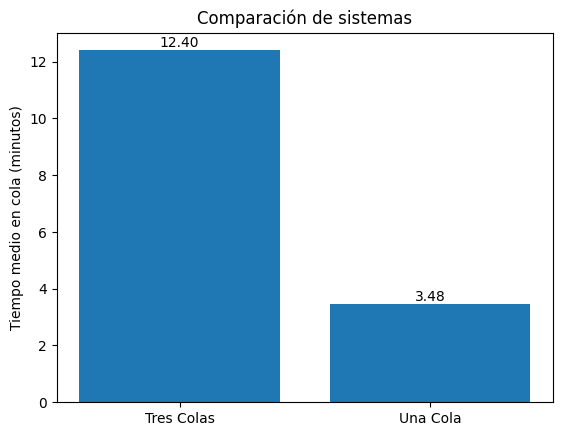

In [126]:
# Crear la figura y los ejes
fig, ax = plt.subplots()
barras = ax.bar(["Tres Colas", "Una Cola"], [media_tres_colas, media_una_cola])

# Agregar etiquetas de valores directamente con bar_label
ax.bar_label(barras, fmt="%.2f")

# Etiquetas
ax.set_ylabel("Tiempo medio en cola (minutos)")
ax.set_title("Comparación de sistemas")

# Mostrar la gráfica
plt.show()

### Comparación del tiempo de espera en el sistema

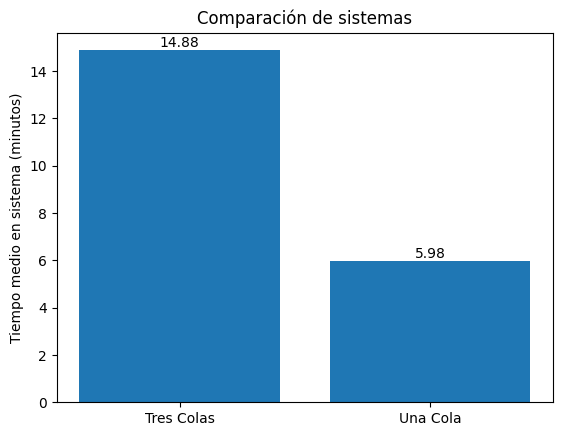

In [127]:
# Crear la figura y los ejes
fig, ax = plt.subplots()
barras = ax.bar(["Tres Colas", "Una Cola"], [media_tres_colas_sistema, media_una_cola_sistema])

# Agregar etiquetas de valores directamente con bar_label
ax.bar_label(barras, fmt="%.2f")

# Etiquetas
ax.set_ylabel("Tiempo medio en sistema (minutos)")
ax.set_title("Comparación de sistemas")

# Mostrar la gráfica
plt.show()

### Comparación de clientes en la cola en el tiempo

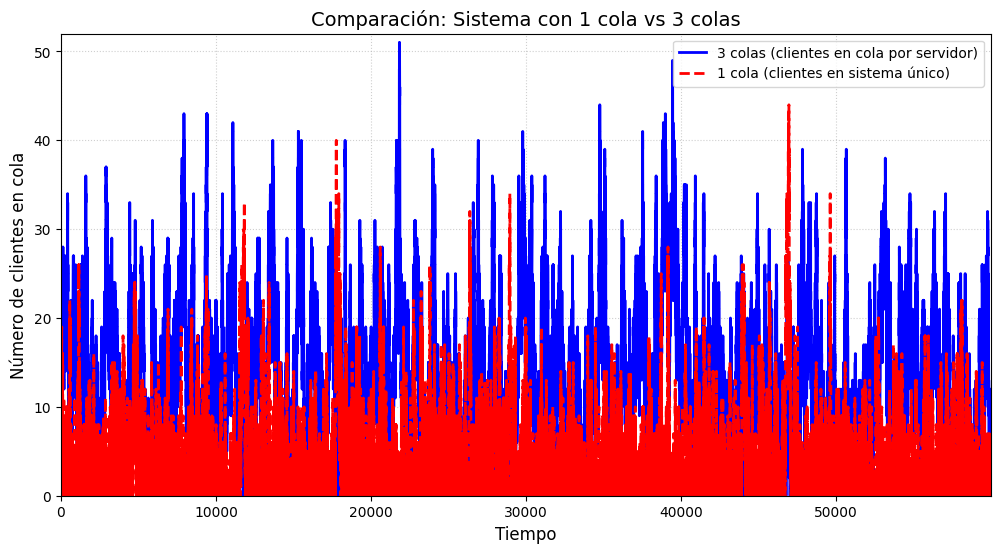

In [129]:
# Datos para 3 colas
tiempos_3_colas = sorted(clientes_en_cola_dict.keys())
clientes_3_colas = [clientes_en_cola_dict[t] for t in tiempos_3_colas]

# Datos para 1 cola
tiempos_1_cola = sorted(clientes_en_cola_dict_una_cola.keys())
clientes_1_cola = [clientes_en_cola_dict_una_cola[t] for t in tiempos_1_cola]

plt.figure(figsize=(12, 6))

# Gráfica para 3 colas
plt.step(
    tiempos_3_colas, 
    clientes_3_colas, 
    where='post', 
    label='3 colas (clientes en cola por servidor)',
    color='blue',
    linestyle='-',
    linewidth=2
)

# Gráfica para 1 cola
plt.step(
    tiempos_1_cola, 
    clientes_1_cola, 
    where='post', 
    label='1 cola (clientes en sistema único)',
    color='red',
    linestyle='--',
    linewidth=2
)

# Personalización
plt.xlabel('Tiempo', fontsize=12)
plt.ylabel('Número de clientes en cola', fontsize=12)
plt.title('Comparación: Sistema con 1 cola vs 3 colas', fontsize=14)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(fontsize=10, loc='upper right')
plt.xlim(0, max(max(tiempos_3_colas), max(tiempos_1_cola)))  # Ajustar límites del eje X
plt.ylim(0, max(max(clientes_3_colas), max(clientes_1_cola)) + 1)  # Ajustar eje Y

plt.show()

### Comparación de clientes en el sistema en el tiempo

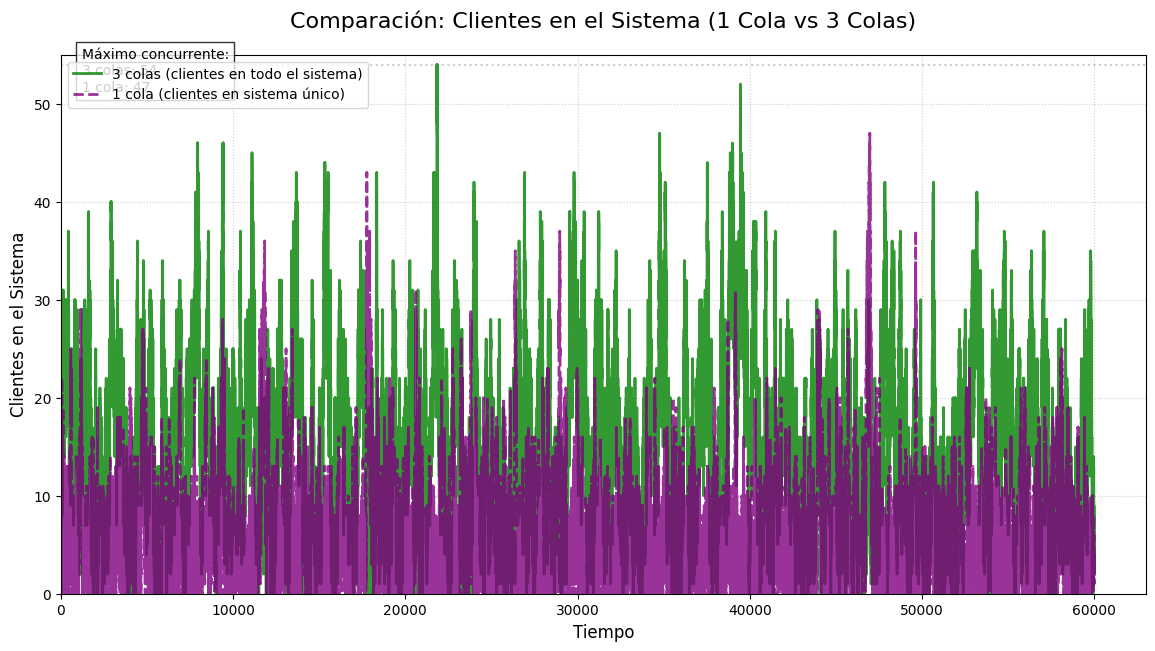

In [130]:
# Preparar datos para 3 colas
tiempos_3_colas = sorted(clientes_en_sistema_dict.keys())
clientes_3_colas = [clientes_en_sistema_dict[t] for t in tiempos_3_colas]

# Preparar datos para 1 cola
tiempos_1_cola = sorted(clientes_en_sistema_dict_una_cola.keys())
clientes_1_cola = [clientes_en_sistema_dict_una_cola[t] for t in tiempos_1_cola]

# Crear la figura
plt.figure(figsize=(14, 7))

# Gráfica para 3 colas (sistema completo)
plt.step(
    tiempos_3_colas, 
    clientes_3_colas, 
    where='post', 
    label='3 colas (clientes en todo el sistema)',
    color='green',
    linestyle='-',
    linewidth=2,
    alpha=0.8
)

# Gráfica para 1 cola (sistema único)
plt.step(
    tiempos_1_cola, 
    clientes_1_cola, 
    where='post', 
    label='1 cola (clientes en sistema único)',
    color='purple',
    linestyle='--',
    linewidth=2,
    alpha=0.8
)

# Personalización
plt.title('Comparación: Clientes en el Sistema (1 Cola vs 3 Colas)', fontsize=16, pad=20)
plt.xlabel('Tiempo', fontsize=12)
plt.ylabel('Clientes en el Sistema', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(fontsize=10, loc='upper left')

# Ajustar límites para mejor visualización
max_tiempo = max(max(tiempos_3_colas), max(tiempos_1_cola))
max_clientes = max(max(clientes_3_colas), max(clientes_1_cola))
plt.xlim(0, max_tiempo * 1.05)  # 5% de margen
plt.ylim(0, max_clientes + 1)

# Destacar métricas clave
plt.axhline(y=max_clientes, color='gray', linestyle=':', alpha=0.4)
plt.text(
    x=max_tiempo * 0.02, 
    y=max_clientes * 0.95, 
    s=f'Máximo concurrente:\n3 colas: {max(clientes_3_colas)}\n1 cola: {max(clientes_1_cola)}',
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.show()